# Tensor-To-Structure (tts) Tutorial

In [1]:
# Turn off GPU support for the tutorial
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensor_to_structure as tts
import tensor_to_structure.utilities as tts_utilities
import pickle
from rdkit import Chem

# For density tensor generation
from moleculekit.tools.voxeldescriptors import getVoxelDescriptors
import numpy as np

# For Mayavi vizualization

%gui qt

# Rerun this cell to load changes in the ttf module
import importlib
importlib.reload(tts)
importlib.reload(tts_utilities)

<module 'tensor_to_structure.utilities' from '/home/simon/skoltech/chemoinformatics/project/tensor_to_structure/tensor_to_structure/utilities.py'>

## 1.0 Data structures

### 1.1 Atom and Molecule

Basic objects of the tts module are *Atom* and *Molecule*. Let's create molecule with one carbon atom.

In [2]:
# Place it at the origin of coordinates
coordinates = tts.Coordinates(0.0, 0.0, 0.0)

# Atom type could be any integer. Carbon's atomic number will work, but if 
# there would be several carbon channels (e.g. for aromatic and not), I would 
# chose different id for each channel.
atom_type = 6

c_atom = tts.Atom(coordinates, atom_type)

my_molecule = tts.Molecule()

# Molecule, basically is just a container:
my_molecule.add_atom(c_atom)
print("Atoms:", my_molecule.atoms)
print("Total atoms:", len(my_molecule))

Atoms: [<tensor_to_structure.Atom object at 0x7f59b530a040>]
Total atoms: 1


In [3]:
# Let's add one more carbon atom
c_atom_second = tts.Atom((1.0, 0.0, 0.0), 6)
my_molecule.add_atom(c_atom_second)
print("Atoms:", my_molecule.atoms)
print("Total atoms:", len(my_molecule))
print()

# Molecule can be created out of atom list
same_molecule = tts.Molecule([c_atom, c_atom_second])
print("Atoms:", same_molecule.atoms)
print("Total atoms:", len(same_molecule))

Atoms: [<tensor_to_structure.Atom object at 0x7f59b530a040>, <tensor_to_structure.Atom object at 0x7f59b5310250>]
Total atoms: 2

Atoms: [<tensor_to_structure.Atom object at 0x7f59b530a040>, <tensor_to_structure.Atom object at 0x7f59b5310250>]
Total atoms: 2


In [4]:
# There are already function for converting rdkit molecules into Molecules.
# Run 'rdkit_to_molecule??' to read it.
rdkit_molecule = Chem.MolFromSmiles('CC')
generated_molecule = tts_utilities.rdkit_to_molecule(rdkit_molecule)
print("Atoms:", generated_molecule.atoms)
print("Total atoms:", len(generated_molecule))

Atoms: [<tensor_to_structure.Atom object at 0x7f59b53178b0>, <tensor_to_structure.Atom object at 0x7f59b530a490>]
Total atoms: 2


### 1.2 AtomDescriptor

In order to use Fitter, we need specify how to generate density tensors out of Molecule objects. AtomDescriptor contain atom radius and set of used channels. Let's create a map from atom types to their descriptors.

In [5]:
# We will use C, N and O. For this tutorial I decided to
# place each atom type in separate channel and I use fourth
# channel for occupancy indication.

simple_atom_type_to_descriptor = {
    # Carbon is placed in 0 channel and its van der waals radius is 1.4 A
    6: tts.AtomDescriptor(1.4, {0, 3}),
    7: tts.AtomDescriptor(1.35, {1, 3}),
    8: tts.AtomDescriptor(1.3, {2, 3}),
}

In [6]:
# In order to describe density tensors creation, user
# need to code a function that takes a Molecule object
# and return a tensor. For this tutorial I use moleculekit.

def molecule_to_tensor(molecule, **kwargs):
    """Example function for conversion struct to tensor by moleculekit.

    molecule -- Molecule object.
    """
    total_channels = 4
    
    molecule_channels = np.zeros((len(molecule), total_channels))
    for i, atom in enumerate(molecule.atoms):
        radius, atom_channels = simple_atom_type_to_descriptor[atom.atom_type]
        for channel in atom_channels:
            molecule_channels[i][channel] = radius

    coords = np.zeros((len(molecule), 3, 1))
    for i, atom in enumerate(molecule.atoms):
        coords[i][0][0], coords[i][1][0], coords[i][2][0] = atom.coordinates

    vox, center, shape = getVoxelDescriptors(None,
                                             voxelsize=0.5,
                                             buffer=1,
                                             boxsize=[20, 20, 20],
                                             center=[0, 0, 0],
                                             userchannels=molecule_channels,
                                             usercoords=coords)
    vox = vox.reshape((40, 40, 40, total_channels))
    return vox

In [7]:
# Let's look at our Molecule
density_tensor = molecule_to_tensor(my_molecule)
tts_utilities.plot_molecule(density_tensor)

In [8]:
# Close all visualization windows
tts_utilities.close_mlab()

## 2.0 Molecule Fitting

### 2.1 Propane

Let's convert density tensors back to Molecule objects.

In [9]:
# Create simple molecule
molecule = Chem.MolFromSmiles('CCC')
molecule = tts_utilities.rdkit_to_molecule(molecule)
density_tensor = molecule_to_tensor(molecule)

# Create Fitter object
fitter = tts.Fitter(molecule_to_tensor_func=molecule_to_tensor,
                    atom_type_to_descriptor=simple_atom_type_to_descriptor)

Conversion could take time. If you see good enough norm (< 0.1), just interrupt the run. It will return 10 best results.

In [10]:
result = fitter.tensor_to_molecule(density_tensor)

2021-06-23 18:57:50,960 - tensor_to_structure.dfs - INFO - DFS step. Depth: 3 Best norm: 0.0023218294401596276
2021-06-23 18:57:50,968 - tensor_to_structure.dfs - INFO - DFS step. Depth: 4 Best norm: 0.0023218294401596276
2021-06-23 18:57:50,974 - tensor_to_structure.dfs - INFO - DFS step. Depth: 2 Best norm: 0.0023218294401596276
2021-06-23 18:57:59,776 - tensor_to_structure.dfs - INFO - DFS step. Depth: 3 Best norm: 0.0023218294401596276
2021-06-23 18:57:59,783 - tensor_to_structure.dfs - INFO - DFS step. Depth: 4 Best norm: 0.0023218294401596276
2021-06-23 18:57:59,790 - tensor_to_structure.dfs - INFO - DFS step. Depth: 6 Best norm: 0.0023218294401596276
2021-06-23 18:57:59,797 - tensor_to_structure.dfs - INFO - DFS step. Depth: 5 Best norm: 0.0023218294401596276
2021-06-23 18:57:59,803 - tensor_to_structure.dfs - INFO - DFS step. Depth: 1 Best norm: 0.0023218294401596276
2021-06-23 18:58:06,235 - tensor_to_structure.dfs - INFO - DFS step. Depth: 5 Best norm: 0.0018991061914854321
2

In [11]:
print('Top 3 molecules:')
for (norm, molecule) in result[:3]:
    print('Norm of difference beetween density tensors', norm)
    print('Atoms:', molecule)
    print()

Top 3 molecules:
Norm of difference beetween density tensors 0.001513663216323078
Atoms: A(1.260417651716951 0.2298159973391964 -0.04426220886716626 6), A(-0.06455675556706483 -0.17769449523268208 0.5929479335749775 6), A(-1.2110300309077928 -0.09376864944735179 -0.4101164661339662 6), A(-0.06462231567513002 -0.17765881282250487 0.5928503742194371 6), A(-0.06467124669716563 -0.17766721305284344 0.5928047127759106 6)

Norm of difference beetween density tensors 0.0018991061914854321
Atoms: A(-1.2110595197993932 -0.09376667030471461 -0.41014901874340826 6), A(1.2604106854012478 0.22981892089898184 -0.04428538291686311 6), A(-0.06457100915744851 -0.17771394553192124 0.5929179100775033 6)

Norm of difference beetween density tensors 0.0019644407095383075
Atoms: A(-0.06458724856955213 -0.17768709965088442 0.5928962579661508 6), A(1.2603795344234638 0.22981676704294052 -0.044275561235480265 6), A(-1.2110410275892443 -0.0937979386580634 -0.4100970165811105 6)



You should get molecules with three carbon atoms and low norm about 0.002. Now let's compute density for best suggested molecule and compare it with the original tensor.

In [12]:
generated_tensor = molecule_to_tensor(result[0][1])

# Show two tensors in 3D
tts_utilities.plot_side_by_side(before=density_tensor, after=generated_tensor)

In [13]:
# Close all visualization windows
tts_utilities.close_mlab()

### 2.2 Indole

Let's try more interesting molecule with two aromatic rings.

In [14]:
molecule = Chem.MolFromSmiles('C1=CC=C2C(=C1)C=CN2') # Indole
molecule = tts_utilities.rdkit_to_molecule(molecule)
original_tensor = molecule_to_tensor(molecule)

The optimization could take time, so interrupt the run when the norm is good enough.

In [15]:
result = fitter.tensor_to_molecule(original_tensor)

2021-06-23 18:58:15,707 - tensor_to_structure.dfs - INFO - DFS step. Depth: 4 Best norm: 17.354143436172222
2021-06-23 18:58:15,715 - tensor_to_structure.dfs - INFO - DFS step. Depth: 3 Best norm: 17.354143436172222
2021-06-23 18:58:15,722 - tensor_to_structure.dfs - INFO - DFS step. Depth: 2 Best norm: 17.354143436172222
2021-06-23 18:58:49,987 - tensor_to_structure.dfs - INFO - DFS step. Depth: 6 Best norm: 9.59998852007064
2021-06-23 18:58:51,265 - tensor_to_structure.dfs - INFO - DFS step. Depth: 7 Best norm: 6.447043274537217
2021-06-23 18:58:51,273 - tensor_to_structure.dfs - INFO - DFS step. Depth: 6 Best norm: 6.447043274537217
2021-06-23 18:58:52,656 - tensor_to_structure.dfs - INFO - DFS step. Depth: 7 Best norm: 6.447043274537217
2021-06-23 18:58:52,665 - tensor_to_structure.dfs - INFO - DFS step. Depth: 6 Best norm: 6.447043274537217
2021-06-23 18:59:15,718 - tensor_to_structure.dfs - INFO - DFS step. Depth: 9 Best norm: 0.00391248767567313
2021-06-23 18:59:15,728 - tensor_

In [16]:
best_molecule = result[0][1]
generated_tensor = molecule_to_tensor(best_molecule)
tts_utilities.plot_side_by_side(original_tensor, generated_tensor)

In [17]:
# Let's look only to carbon channel
tts_utilities.close_mlab()
tts_utilities.plot_side_by_side(original_tensor, generated_tensor, channel=0)

In [18]:
tts_utilities.close_mlab()

### 2.3 Heavy molecule

There are multiple options how to represent atom channels. It's possible that single atom type has several channels and some different types has the same channels. Let's try hard example.

In [19]:
# C, N, O, F, S, Cl, Br 
hard_atom_type_to_descriptor = {
    6: tts.AtomDescriptor(1.4, {0, 4}),
    7: tts.AtomDescriptor(1.35, {1, 4}),
    8: tts.AtomDescriptor(1.3, {2, 3, 4}),
    9: tts.AtomDescriptor(1.25, {1, 4}),
    16: tts.AtomDescriptor(1.6, {1, 2, 4}),
    17: tts.AtomDescriptor(1.58, {1, 2, 3, 4}),
    35: tts.AtomDescriptor(1.7, {0, 2, 4}),
}

def molecule_to_tensor(molecule, **kwargs):
    """Example function for conversion struct to tensor by moleculekit.

    molecule -- Molecule object.
    """
    total_channels = 5
    
    molecule_channels = np.zeros((len(molecule), total_channels))
    for i, atom in enumerate(molecule.atoms):
        radius, atom_channels = hard_atom_type_to_descriptor[atom.atom_type]
        for channel in atom_channels:
            molecule_channels[i][channel] = radius

    coords = np.zeros((len(molecule), 3, 1))
    for i, atom in enumerate(molecule.atoms):
        coords[i][0][0], coords[i][1][0], coords[i][2][0] = atom.coordinates

    vox, center, shape = getVoxelDescriptors(None,
                                             voxelsize=0.5,
                                             buffer=1,
                                             boxsize=[20, 20, 20],
                                             center=[0, 0, 0],
                                             userchannels=molecule_channels,
                                             usercoords=coords)
    vox = vox.reshape((40, 40, 40, total_channels))
    return vox

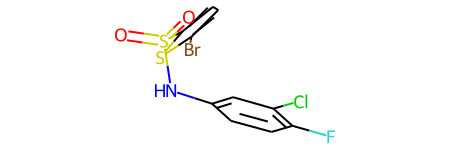

In [20]:
with open('tensor_to_structure/heavy_ligand', 'rb') as f:
    molecule = pickle.load(f)
molecule

In [21]:
molecule = tts_utilities.rdkit_to_molecule(molecule)
original_tensor = molecule_to_tensor(molecule)
fitter = tts.Fitter(molecule_to_tensor_func=molecule_to_tensor,
                    atom_type_to_descriptor=hard_atom_type_to_descriptor)

In [32]:
# Since the optimization will take forever, let's change base settings to the make fitter less accurate.
# Read Fitter code to see other settings or github README.
fitter.max_atom_by_dfs_step = 2
fitter.max_molecules_by_dfs_step = 5

In [33]:
result = fitter.tensor_to_molecule(original_tensor)

2021-06-23 19:13:09,178 - tensor_to_structure.dfs - INFO - DFS step. Depth: 2 Best norm: 51.17723206657693
2021-06-23 19:13:09,791 - tensor_to_structure.dfs - INFO - DFS step. Depth: 4 Best norm: 51.17723206657693
2021-06-23 19:13:16,210 - tensor_to_structure.dfs - INFO - DFS step. Depth: 6 Best norm: 39.74393946754656
2021-06-23 19:13:23,901 - tensor_to_structure.dfs - INFO - DFS step. Depth: 8 Best norm: 32.04297450849689
2021-06-23 19:13:27,747 - tensor_to_structure.dfs - INFO - DFS step. Depth: 10 Best norm: 32.04297450849689
2021-06-23 19:13:32,837 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 19.938541269771466
2021-06-23 19:13:32,844 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 19.938541269771466
2021-06-23 19:13:32,852 - tensor_to_structure.dfs - INFO - DFS step. Depth: 11 Best norm: 19.938541269771466
2021-06-23 19:13:45,789 - tensor_to_structure.dfs - INFO - DFS step. Depth: 13 Best norm: 19.938541269771466
2021-06-23 19:13:45,797 - te

2021-06-23 19:16:10,915 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 19.938541269771466
2021-06-23 19:16:10,922 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 19.938541269771466
2021-06-23 19:16:10,930 - tensor_to_structure.dfs - INFO - DFS step. Depth: 11 Best norm: 19.938541269771466
2021-06-23 19:16:10,937 - tensor_to_structure.dfs - INFO - DFS step. Depth: 7 Best norm: 19.938541269771466
2021-06-23 19:16:14,171 - tensor_to_structure.dfs - INFO - DFS step. Depth: 9 Best norm: 19.938541269771466
2021-06-23 19:16:18,337 - tensor_to_structure.dfs - INFO - DFS step. Depth: 11 Best norm: 19.938541269771466
2021-06-23 19:16:18,344 - tensor_to_structure.dfs - INFO - DFS step. Depth: 11 Best norm: 19.938541269771466
2021-06-23 19:16:18,351 - tensor_to_structure.dfs - INFO - DFS step. Depth: 10 Best norm: 19.938541269771466
2021-06-23 19:16:29,659 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 19.938541269771466
2021-06-23 19:16:29,6

2021-06-23 19:18:44,770 - tensor_to_structure.dfs - INFO - DFS step. Depth: 11 Best norm: 17.705473469492258
2021-06-23 19:18:44,777 - tensor_to_structure.dfs - INFO - DFS step. Depth: 10 Best norm: 17.705473469492258
2021-06-23 19:18:57,330 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 17.705473469492258
2021-06-23 19:18:57,337 - tensor_to_structure.dfs - INFO - DFS step. Depth: 11 Best norm: 17.705473469492258
2021-06-23 19:18:57,345 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 17.705473469492258
2021-06-23 19:18:57,353 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 17.705473469492258
2021-06-23 19:18:57,360 - tensor_to_structure.dfs - INFO - DFS step. Depth: 11 Best norm: 17.705473469492258
2021-06-23 19:18:57,367 - tensor_to_structure.dfs - INFO - DFS step. Depth: 8 Best norm: 17.705473469492258
2021-06-23 19:19:01,460 - tensor_to_structure.dfs - INFO - DFS step. Depth: 10 Best norm: 17.705473469492258
2021-06-23 19:19:01,

2021-06-23 19:23:27,025 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 17.705473469492258
2021-06-23 19:23:27,032 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 17.705473469492258
2021-06-23 19:23:27,040 - tensor_to_structure.dfs - INFO - DFS step. Depth: 13 Best norm: 17.705473469492258
2021-06-23 19:23:27,047 - tensor_to_structure.dfs - INFO - DFS step. Depth: 10 Best norm: 17.705473469492258
2021-06-23 19:23:55,537 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 17.705473469492258
2021-06-23 19:23:55,547 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 17.705473469492258
2021-06-23 19:23:55,556 - tensor_to_structure.dfs - INFO - DFS step. Depth: 11 Best norm: 17.705473469492258
2021-06-23 19:23:55,565 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 17.705473469492258
2021-06-23 19:23:55,574 - tensor_to_structure.dfs - INFO - DFS step. Depth: 11 Best norm: 17.705473469492258
2021-06-23 19:23:55

2021-06-23 19:30:16,497 - tensor_to_structure.dfs - INFO - DFS step. Depth: 10 Best norm: 17.705473469492258
2021-06-23 19:30:16,508 - tensor_to_structure.dfs - INFO - DFS step. Depth: 10 Best norm: 17.705473469492258
2021-06-23 19:30:16,518 - tensor_to_structure.dfs - INFO - DFS step. Depth: 10 Best norm: 17.705473469492258
2021-06-23 19:30:16,527 - tensor_to_structure.dfs - INFO - DFS step. Depth: 9 Best norm: 17.705473469492258
2021-06-23 19:30:16,537 - tensor_to_structure.dfs - INFO - DFS step. Depth: 10 Best norm: 17.705473469492258
2021-06-23 19:30:25,326 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 17.705473469492258
2021-06-23 19:30:25,336 - tensor_to_structure.dfs - INFO - DFS step. Depth: 11 Best norm: 17.705473469492258
2021-06-23 19:30:25,351 - tensor_to_structure.dfs - INFO - DFS step. Depth: 9 Best norm: 17.705473469492258
2021-06-23 19:30:52,966 - tensor_to_structure.dfs - INFO - DFS step. Depth: 11 Best norm: 17.705473469492258
2021-06-23 19:30:52,9

2021-06-23 19:36:10,444 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 17.705473469492258
2021-06-23 19:36:10,470 - tensor_to_structure.dfs - INFO - DFS step. Depth: 13 Best norm: 17.705473469492258
2021-06-23 19:36:10,486 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 17.705473469492258
2021-06-23 19:36:10,502 - tensor_to_structure.dfs - INFO - DFS step. Depth: 13 Best norm: 17.705473469492258
2021-06-23 19:36:10,516 - tensor_to_structure.dfs - INFO - DFS step. Depth: 10 Best norm: 17.705473469492258
2021-06-23 19:36:32,077 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 17.705473469492258
2021-06-23 19:36:32,089 - tensor_to_structure.dfs - INFO - DFS step. Depth: 11 Best norm: 17.705473469492258
2021-06-23 19:36:32,101 - tensor_to_structure.dfs - INFO - DFS step. Depth: 11 Best norm: 17.705473469492258
2021-06-23 19:36:32,114 - tensor_to_structure.dfs - INFO - DFS step. Depth: 12 Best norm: 17.705473469492258
2021-06-23 19:36:32

In [34]:
best_molecule = result[0][1]
generated_tensor = molecule_to_tensor(best_molecule)
tts_utilities.plot_side_by_side(original_tensor, generated_tensor)

In [35]:
tts_utilities.close_mlab()